In [1]:
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings(action='ignore')

합성곱 신경망(Convolution Neural Network, CNN)  

합성곱 신경망은 흔히 CNN이라고 부르는 방법으로 합성곱이라는 연산을 사용하는 신경망이다. CNN은 실제 여러 분야에서 사용되는 방법으로 특히 이미지 분류 작업에서 좋은 성능을 보여준다.

합성곱 연산은 아래와 같은 연산을 의미한다.

$$y(i) = (x \times w)(i) = \sum_{k=-\infty}^{\infty} x(k)w(i - k)$$

위 식은 $i$ 시점에서의 입력 데이터 $x$ 값과 가중치 $w$ 값의 합성곱 연산의 결과는 $y(i)$와 같음을 나타낸다. 위 식에서는 $k$도 시점을 의미하는데, 자세히 보면 가중치 $w$의 시점은 $w(i)$가 아닌 $w(i - k)$임을 알 수 있다. 이를 플립(flip)이라고 하며 가중치 커널(kernel)이라고도 부른다. 플립은 우리말로 하면 '뒤집다'라는 뜻으로 가중치의 시점을 뒤집는다는 뜻이다. 위 식은 시점의 순서와 상관없이 결과가 동일하므로 아래와 같이 쓸 수도 있다.

$$y(i) = (x \times w)(i) = \sum_{k=-\infty}^{\infty} x(i - k)w(k)$$

패딩(Padding)  
패딩은 입력 데이터 주변을 특정 값으로 채우는 것을 의미한다.

<img src="./data/cnn_1.png" width="500"/>

신경망에 커널을 적용하면 층이 깊어질수록 데이터의 차원은 점차 줄어든다. 4 * 4 차원의 입력 데이터에 2 * 2 커널을 합성곱했을 때 출력 데이터의 차원은 3 * 3으로 입력 데이터보다 출력 데이터가 줄어든다. 이렇듯, 입력 데이터에 커널을 합성곱한 후 출력 데이터의 차원이 줄어드는 현상을 방지하기 위해서 패딩이라는 방법을 사용한다.

스트라이드(Stride)  
스트라이드는 한 번 합성곱 연산을 한 후 다음 계산 영역을 선택할 때 얼마나 이동할지 간격을 정하는 것이다.

<img src="./data/cnn_2.png" width="400"/>

스트라이드 2를 적용한 후 합성곱 연산을 한 결과를 스트라이드 1 때와 비교해 보면 출력 데이터 행렬의 차원이 더 작은 것을 알 수 있다.

풀링(Pooling)  
풀링은 데이터의 차원을 줄이는 방법이다.

<img src="./data/cnn_3.png" width="300"/>

맥스 풀링(max pooling)이란 해당 영역에서 가장 큰 값을 선택하는 방법이다.

합성곱 신경망 실습  
합성곱 신경망을 이용해 손글씨 인식 모형을 생성해본다.

In [2]:
# 동일한 결과를 보기 위해 랜덤 시드를 설정한다.
import numpy as np
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
# 데이터 불러오기, mnist 데이터는 텐서플로우에서 제공하는 데이터셋이다.
from tensorflow.keras import datasets # mnist 손글씨 데이터를 불러오기 위해 import 한다.
# mnist 데이터는 불러올 때, 트레이닝 데이터와 테스트 데이터를 나눠서 불러온다.
# load_data() 함수는 (트레이닝 피쳐 데이터, 트레이닝 타겟 데이터)과 (테스트 피쳐 데이터, 테스트 타겟 데이터)을
# 튜플 형태로 묶어서 리턴한다.
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data() # 손글씨 데이터셋을 불러온다.

In [4]:
# 오리지널 데이터 차원 확인
# 트레이닝 피쳐 데이터의 차원을 확인하면 (이미지 개수, 행, 열) 형태로 나온다. 즉, 트레이닝 피처 데이터는 28행 * 28열
# 이미지 60,000개로 구성되어 있다는 것을 알 수 있다.
print(X_train.shape)
print(y_train.shape) # 트레이닝 타겟 데이터는 스칼라값 60,000개로 이루어진 벡터이다.
print(X_test.shape) # 테스트 피처 데이터는 28행 * 28열 이미지 10,000개로 구성되어 있다는 것을 알 수 있다.
print(y_test.shape) # 테스트 타겟 데이터는 스칼라값 10,000개로 이루어진 벡터이다.

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


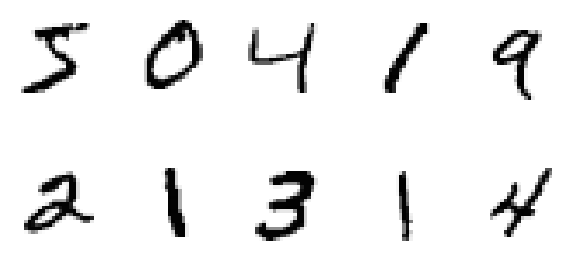

[5 0 4 1 9 2 1 3 1 4]


In [5]:
# 오리지날 데이터 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1) # 서브 플롯을 설정한다.
    plt.imshow(X_train[i].reshape((28, 28)), cmap='Greys') # i번째 손글씨 데이터를 시각화 한다.
    plt.axis(False) # 축 레이블 감추기, plt.axis('off')
plt.show()
print(y_train[:10])

In [6]:
# 타겟 클래스 확인
# 타겟 데이터의 종류를 확인하면 손글씨를 어떤 형태로 구분하는지, 총 몇 가지 숫자를 구분하는지 알 수 있다.
# 결과를 확인하니 mnist 데이터는 0 부터 9까지 숫자를 구분하는 데이터임을 알 수 있다.
print(set(y_train))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [7]:
# 피처 데이터 스케일 조정
# 오리지널 데이터의 차원은 (이미지 개수, 행, 열) 형태의 3차원 형태로 표현했지만 합성곱 신경망에 데이터를 넣으려면
# 4차원 형태의 (이미지 개수, 행, 열, 채널 수) 형태로 구성해야 한다.
# 합성곱 신경망의 입력 데이터는 (이미지 개수, 행, 열, 채널 수) 형태로 구성된다. 이때, 채널이란 흔히 RGB로 구분되는
# 것을 의미하는데, 만약 하나의 이미지 데이터를 R을 이용한 픽셀값, G을 이용한 필셀값, B를 이용한 픽셀값으로 나타낼 때,
# 채널 수는 3이 된다. 하지만 딥러닝 분석에 사용되는 mnist 데이터는 채널 1개의 데이터이므로 채널 수는 1이 된다.
# 이미지 변형은 reshape() 함수를 이용해 (이미지 개수, 행, 열, 채널 수) 형태로 변경한다.
X_tn_re = X_train.reshape(60000, 28, 28, 1) # 트레이닝 피쳐 데이터의 차원을 바꿔준다.
X_tn = X_tn_re / 255 # 이미지 픽셀값은 0 ~ 255 사이에 있으므로 최대값이 1이 되도록 조정한다.
print(X_tn.shape)
X_te_re = X_test.reshape(10000, 28, 28, 1) # 테스트 피쳐 데이터의 차원을 바꿔준다.
X_te = X_te_re / 255
print(X_te.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [8]:
# 타겟 데이터 원-핫 인코딩
from tensorflow.keras.utils import to_categorical # 원-핫 인코딩을 하기 위해 import 한다.
y_tn = to_categorical(y_train) # 트레이닝 타겟 데이터를 원-핫 인코딩한다.
y_te = to_categorical(y_test) # 테스트 타겟 데이터를 원-핫 인코딩한다.

In [9]:
# 합성곱 신경망 생성에 필요한 라이브러리 import
from tensorflow.keras.models import Sequential # 신경망 모형 생성을 하기 위해 import 한다.
from tensorflow.keras.layers import Dense, Conv2D # 신경망 모형에 layer를 추가하기 위해 import 한다.
from tensorflow.keras.layers import MaxPool2D # 신경망 모형에 맥스 풀링을 적용하기 위해 import 한다.
from tensorflow.keras.layers import Flatten # 신경망 모형을 최종 배열 형태로 만들기 위해 import 한다.
from tensorflow.keras.layers import Dropout # 신경망 모형에 Dropout을 적용하기 위해 import 한다.
n_class = len(set(y_train))
# print(n_class) # 10

In [10]:
# CNN 모형을 만든다.
model = Sequential()
# 입력층을 추가한다.
# filters 옵션으로 출력 데이터 차원을 지정한다.
# input_shape 옵션으로 입력 데이터의 차원을 지정한다.
# kernel_size 옵션으로 커널 크기를 지정한다.
# padding 옵션으로 패딩 방법을 지정한다. valid는 패딩을 하지 않겠다는 뜻이고 same은 패딩을 하겠다는 뜻이다.
# activation 옵션으로 활성화 함수를 지정한다.
model.add(Conv2D(filters=32, input_shape=(28, 28, 1), kernel_size=(5, 5), padding='valid', activation='relu'))
# Conv2D의 output shape은 입력 데이터 차원 수 + 1 - 커널의 차원 수로 결정된다. 28 + 1 - 5 = 24, (None, 24, 24, 32)
# Param은 kernel_size(5 * 5) * 입력 채널 크기(1) * filters(32) + filters마다 1개씩의 바이어스(32)로 결정된다.
# 5 * 5 * 1 * 32 + 32 = 832
# 맥스 풀링층을 추가한다.
# pool_size 옵션으로 맥스 풀링 할 픽셀 크기를 지정한다.
model.add(MaxPool2D(pool_size=(2, 2)))
# MaxPool2D의 output shape은 입력 데이터 차원 수 / pool_size(2)로 결정된다. 24 / 2 => 12, (None, 12, 12, 32)
# MaxPool2D은 Param이 없으므로 0이다.
# Dropout() 함수의 인수로 사용하지 않을 노드의 비율을 지정해서 드롭 아웃층을 추가한다. 
model.add(Dropout(0.25))
# Dropout은 output shape이 변경되지 않고 Param도 없다.
# 은닉층을 추가한다.
# 입력층의 출력이 히든층의 입력으로 들어오므로 input_shape 속성은 지정하지 않는다.
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation='relu'))
# Conv2D의 output shape은 입력 데이터 차원 수 + 1 - 커널의 차원 수로 결정된다. 12 + 1 - 3 = 10, (None, 10, 10, 32)
# Param은 kernel_size(3 * 3) * 입력 채널 크기(32) * filters(32) + filters마다 1개씩의 바이어스(32)로 결정된다.
# 3 * 3 * 32 * 32 + 32 = 9248
# 맥스 풀링층을 추가한다.
model.add(MaxPool2D(pool_size=(2, 2)))
# MaxPool2D의 output shape은 입력 데이터 차원 수 / pool_size(2)로 결정된다. 10 / 2 => 5, (None, 5, 5, 32)
# MaxPool2D은 Param이 없으므로 0이다.
# Dropout() 함수의 인수로 사용하지 않을 노드의 비율을 지정해서 드롭 아웃층을 추가한다. 
model.add(Dropout(0.25))
# Dropout은 output shape이 변경되지 않고 Param도 없다.
# 최종 출력층에서 소프트맥스 활성화 함수를 사용하기 위해서 벡터 형태로 펼쳐준다. => 1차원으로 만든다.
model.add(Flatten())
# Flatten()은 3차원 (5, 5, 32) 데이터를 벡터 형태로 펼쳐 주므로 5 * 5 * 32 = 800, (None, 800)
# Flatten Param이 없으므로 0이다.
# 최종 출력층을 추가한다.
model.add(Dense(units=1024, activation='relu'))
# Dense의 output shape은 units의 크기로 결정된다. (None, 1024)
# Param은 (입력 크기(800) + 바이어스(1)) * 출력 크기(1024)로 결정된다. (800 + 1) * 1024 = 820224
# Dropout() 함수의 인수로 사용하지 않을 노드의 비율을 지정해서 드롭 아웃층을 추가한다. 
model.add(Dropout(0.5))
# Dropout은 output shape이 변경되지 않고 Param도 없다.
# 활성화 함수로 소프트맥스를 설정한 후 최종 출력층을 구해준다.
model.add(Dense(units=n_class, activation='softmax'))
# Dense의 output shape은 units의 크기로 결정된다. (None, 10)
# Param은 (입력 크기(1024) + 바이어스(1)) * 출력 크기(n_class(10))로 결정된다. (1024 + 1) * 10 = 10250
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0

In [11]:
# 모형 컴파일
# 다중 분류 작업이므로 손실 함수는 categorical_crossentropy를 최적화 함수는 adam을 모델의 성능 평가는 accurcay를
# 사용한다.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
# 모형 학습
# 트레이닝 데이터 X_tn을 사용해 배치 사이즈 100으로 설정해 학습한다. => epoch가 커질 수록 정확도가 올라간다.
hist = model.fit(X_tn, y_tn, epochs=10, batch_size=100)

Epoch 1/10
600/600 [==============================] - 76s 120ms/step - loss: 0.2285 - accuracy: 0.9289
Epoch 2/10
600/600 [==============================] - 68s 113ms/step - loss: 0.0749 - accuracy: 0.9760
Epoch 3/10
600/600 [==============================] - 187s 311ms/step - loss: 0.0573 - accuracy: 0.9823
Epoch 4/10
600/600 [==============================] - 38s 63ms/step - loss: 0.0466 - accuracy: 0.9851
Epoch 5/10
600/600 [==============================] - 52s 87ms/step - loss: 0.0422 - accuracy: 0.9869
Epoch 6/10
600/600 [==============================] - 70s 116ms/step - loss: 0.0347 - accuracy: 0.9884
Epoch 8/10
600/600 [==============================] - 69s 115ms/step - loss: 0.0336 - accuracy: 0.9895
Epoch 9/10
600/600 [==============================] - 66s 110ms/step - loss: 0.0286 - accuracy: 0.9908
Epoch 10/10
600/600 [==============================] - 67s 112ms/step - loss: 0.0287 - accuracy: 0.9908


In [13]:
# 모델 평가
print(model.evaluate(X_tn, y_tn))
print(model.evaluate(X_te, y_te))

1875/1875 [==============================] - 23s 12ms/step - loss: 0.0104 - accuracy: 0.99670s - loss: 0.0104 - 
[0.010413076728582382, 0.9967333078384399]
313/313 [==============================] - 5s 13ms/step - loss: 0.0215 - accuracy: 0.9934
[0.02146036922931671, 0.993399977684021]


In [14]:
# 학습한 모델로 예측
y_pred_hot = model.predict(X_te) # 테스트 피쳐 데이터로 예측값을 계산한다.
print(y_test[0]) # 테스트 타겟 데이터
print(y_te[0]) # 테스트 타겟 데이터를 원-핫 인코딩한 결과
print(y_pred_hot[0]) # 테스트 피처 데이터를 학습한 모델로 예측한 결과를 원-핫 인코딩 결과

7
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[1.2025473e-12 1.1873487e-10 4.5060253e-10 5.6430456e-09 2.5175773e-09
 3.6004998e-11 1.2327036e-14 9.9999988e-01 3.3184688e-10 6.7249104e-08]


In [15]:
# 실제값과 예측값의 동일 여부를 확인하기 위해 넘파이 라이브러리를 이용해 예측값을 원-핫 인코딩 형태가 아닌 원본
# 숫자로 변환한다.
import numpy as np
# argmax() 함수를 사용하면 원-핫 인코딩된 값을 원래 숫자로 바꿀 수 있다.
y_pred = np.argmax(y_pred_hot, axis=1)
print(y_pred) # 결과를 확인해 보면 원래 숫자 형태로 돌아온 것을 확인할 수 있다.

[7 2 1 ... 4 5 6]


In [16]:
# 오답 데이터 확인
diff = y_test - y_pred # 실제값과 예측값의 차이를 계산한다.
diff_index = [] # 몇 번째 테스트 데이터가 다르게 예측되었는지 인덱스를 저장할 빈 리스트를 생성한다.
for i in range(len(y_test)): # 테스트 타겟 데이터의 개수만큼 반복한다.
    if diff[i] != 0: # 실제값과 예측값이 다른가?
        diff_index.append(i) # 실제값과 예측값이 다른 데이터의 인덱스를 diff_index 리스트에 추가한다.
print(len(diff_index))
print(diff_index)

66
[321, 445, 449, 582, 625, 646, 659, 947, 1014, 1033, 1112, 1226, 1232, 1242, 1247, 1393, 1530, 1681, 1901, 2070, 2118, 2130, 2135, 2182, 2280, 2293, 2597, 2654, 2896, 2927, 2939, 3289, 3422, 3475, 3520, 3558, 3767, 3985, 4176, 4369, 4571, 4639, 4699, 4740, 4761, 4807, 4823, 4860, 4956, 5265, 5937, 5955, 5997, 6555, 6571, 6576, 6597, 8408, 8527, 9009, 9015, 9642, 9664, 9692, 9729, 9839]


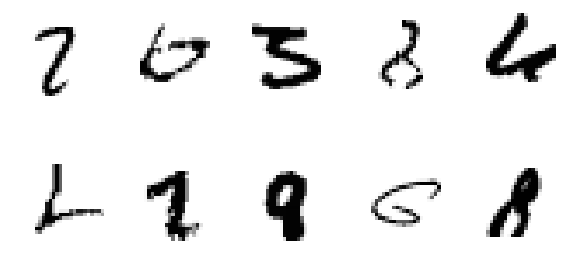

2 6 3 8 6 2 2 8 6 8 
7 0 5 2 4 4 7 9 5 1 

In [17]:
# 오답 데이터 시각화
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[diff_index[i]].reshape((28, 28)), cmap='Greys')
    plt.axis(False)
plt.show()
for i in range(10):
    print(y_test[diff_index[i]], end=' ')
print()
for i in range(10):
    print(y_pred[diff_index[i]], end=' ')